In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector, TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [2]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')

        # read all text
        text = file.read()
        file.close()
        return text

In [3]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    return [i.split('\t') for i in sents]

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# # Tentukan path file
# file_path = '/content/drive/MyDrive/deu.txt'

file_path = 'C:/Users/Syifa Ayu Talitha M/Documents/Intern ASDP/DEPLOYMENT DATA ANALISIS/deu.txt'

# Fungsi untuk membaca file dan memprosesnya
data = read_text(file_path)
deu_eng = to_lines(data)
deu_eng = array(deu_eng)


In [5]:
deu_eng = deu_eng[:10000,:]

In [6]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Tom said hello', 'Tom sagte Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2549605 (CK) & #6615076 (Felixjp)'],
       ['Tom sat calmly', 'Tom saß ruhig da',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2237641 (CK) & #6615062 (Felixjp)'],
       ['Tom sat nearby', 'Tom saß in der Nähe',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2237645 (CK) & #6615063 (Felixjp)']],
      dtype='<U537')

In [7]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

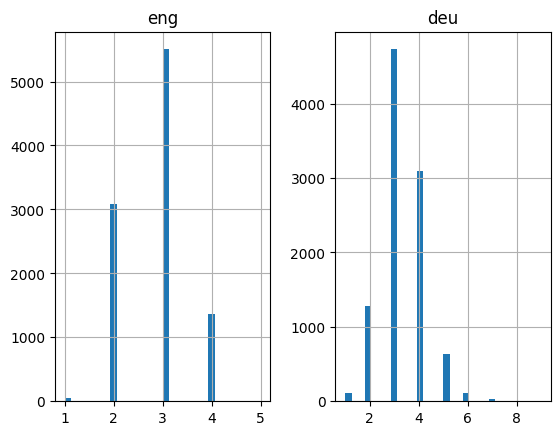

In [8]:
# 1. Analisis Panjang Kalimat
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

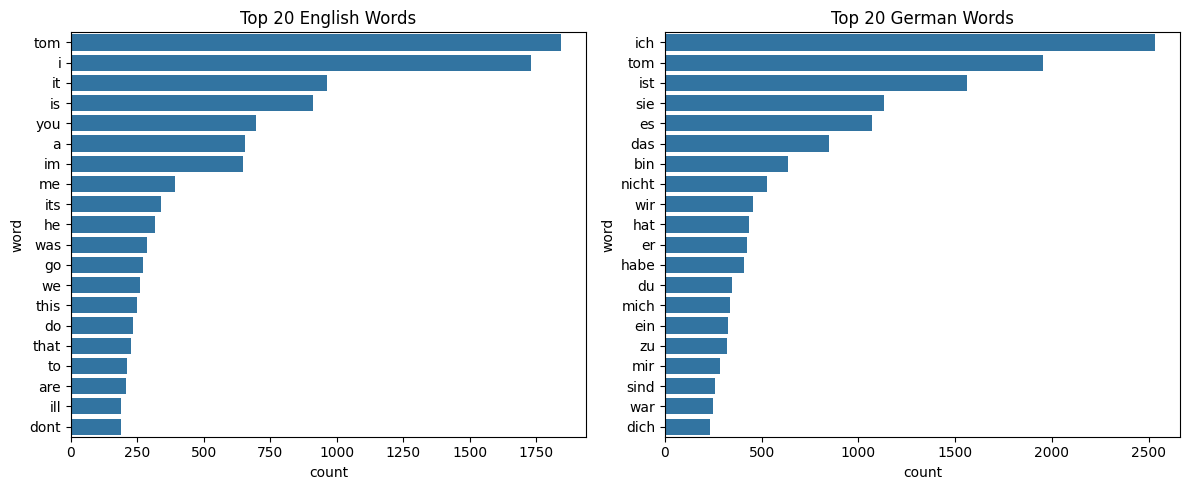

In [9]:
# 2. Frekuensi Data Terbanyak
from collections import Counter
import seaborn as sns

# Gabungkan semua kalimat menjadi satu string
all_eng_words = ' '.join(deu_eng[:,0]).split()
all_deu_words = ' '.join(deu_eng[:,1]).split()

# Hitung frekuensi kata
eng_word_freq = Counter(all_eng_words).most_common(20)
deu_word_freq = Counter(all_deu_words).most_common(20)

# Visualisasi
eng_df = pd.DataFrame(eng_word_freq, columns=['word', 'count'])
deu_df = pd.DataFrame(deu_word_freq, columns=['word', 'count'])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(data=eng_df, x='count', y='word')
plt.title('Top 20 English Words')

plt.subplot(1, 2, 2)
sns.barplot(data=deu_df, x='count', y='word')
plt.title('Top 20 German Words')

plt.tight_layout()
plt.show()


In [10]:
# 3. Distribusi Jumlah Kata Unik
print("Jumlah kata unik dalam Bahasa Inggris:", len(set(all_eng_words)))
print("Jumlah kata unik dalam Bahasa Jerman :", len(set(all_deu_words)))


Jumlah kata unik dalam Bahasa Inggris: 2276
Jumlah kata unik dalam Bahasa Jerman : 3646


In [11]:
# 4. Panjang Kalimat Maksimum, Minimum, dan Rata-rata
print("Panjang kalimat Inggris - min:", min(eng_l), "max:", max(eng_l), "mean:", sum(eng_l)/len(eng_l))
print("Panjang kalimat Jerman  - min:", min(deu_l), "max:", max(deu_l), "mean:", sum(deu_l)/len(deu_l))


Panjang kalimat Inggris - min: 1 max: 5 mean: 2.8171
Panjang kalimat Jerman  - min: 1 max: 9 mean: 3.3356


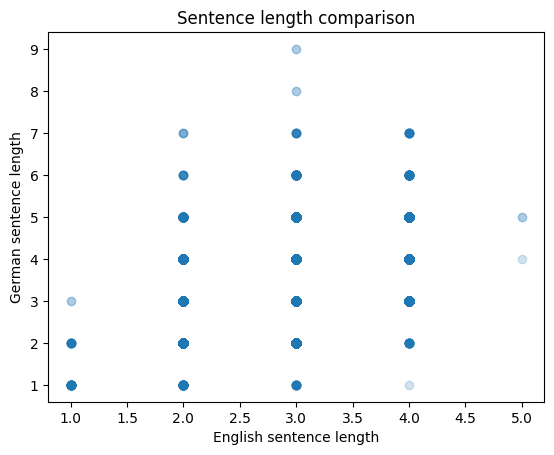

In [12]:
# 5.  Perbandingan Panjang Kalimat Bahasa Inggris vs Jerman
plt.scatter(eng_l, deu_l, alpha=0.2)
plt.xlabel("English sentence length")
plt.ylabel("German sentence length")
plt.title("Sentence length comparison")
plt.show()


In [13]:
# 6. Cek Kalimat Duplikat
print("Jumlah kalimat unik:", len(set(map(tuple, deu_eng))))
print("Jumlah total pasangan kalimat:", len(deu_eng))


Jumlah kalimat unik: 10000
Jumlah total pasangan kalimat: 10000


In [14]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [15]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 2277


In [16]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 3647


In [17]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [18]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [19]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [20]:
def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(input_dim=in_vocab, output_dim=units, mask_zero=True))  # Removed input_length
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model


In [21]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [22]:
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [23]:
# For example, if German is the input:
vocab_size = deu_vocab_size

# Define embedding_dim and max_length
embedding_dim = 128  # Choose an appropriate embedding dimension
max_length = deu_length  # Assuming deu_length is the maximum sequence length for German

# Membangun model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(units=256, return_sequences=True))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

c:\Users\Syifa Ayu Talitha M\Documents\Intern ASDP\DEPLOYMENT DATA ANALISIS\venv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [24]:
filename = 'model.h1.24_jan_19.keras'  # Add the .keras extension to the filename
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=5, batch_size=512, validation_split=0.2, callbacks=[checkpoint],
                    verbose=1)

Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.4863 - loss: 7.8181
Epoch 1: val_loss improved from inf to 4.16857, saving model to model.h1.24_jan_19.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 932ms/step - accuracy: 0.4940 - loss: 7.7682 - val_accuracy: 0.6478 - val_loss: 4.1686
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.6491 - loss: 3.4896
Epoch 2: val_loss improved from 4.16857 to 2.78794, saving model to model.h1.24_jan_19.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 557ms/step - accuracy: 0.6490 - loss: 3.4651 - val_accuracy: 0.6478 - val_loss: 2.7879
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.6482 - loss: 2.7589
Epoch 3: val_loss improved from 2.78794 to 2.68520, saving model to model.h1.24_jan_19.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 609ms/step - accuracy: 0.6482 - loss: 2.7568 - val_accuracy: 0.6478 - val_loss: 2.6852
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.6476 - loss: 2.6382
Epoch 4: val_loss improved from 

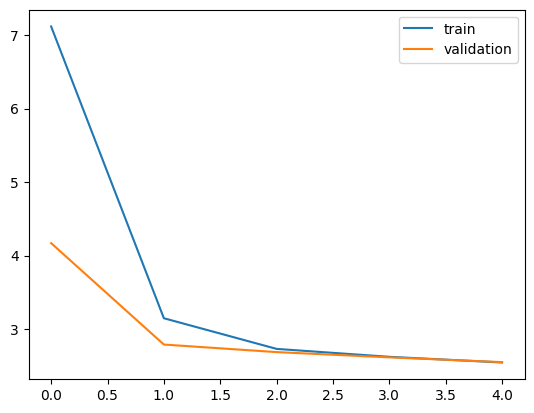

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()


In [26]:
from keras.models import load_model
from numpy import argmax

model = load_model('model.h1.24_jan_19.keras')
preds = model.predict(testX, verbose=0)
preds = argmax(preds, axis=-1)


In [27]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [28]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)

    preds_text.append(' '.join(temp))

In [29]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [30]:
# print 15 rows randomly
pred_df.head(15)

,actual,predicted
0,i love garlic,
1,it was on sale,
2,who are you,
3,is it for here,
4,send it to me,
5,tom is loving,
6,i was bullied,
7,tom got hacked,
8,tom just ate,
9,tom saw me,


In [32]:
from nltk.translate.bleu_score import corpus_bleu

actual = [[sentence.split()] for sentence in test[:, 0]]  # referensi
predicted = [sentence.split() for sentence in preds_text]  # hasil prediksi

print('BLEU score:', corpus_bleu(actual, predicted))


BLEU score: 6.93691943797616e-295


c:\Users\Syifa Ayu Talitha M\Documents\Intern ASDP\DEPLOYMENT DATA ANALISIS\venv\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Syifa Ayu Talitha M\Documents\Intern ASDP\DEPLOYMENT DATA ANALISIS\venv\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Syifa Ayu Talitha M\Documents\Intern ASDP\DEPLOYMENT DATA ANALISIS\venv\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore th

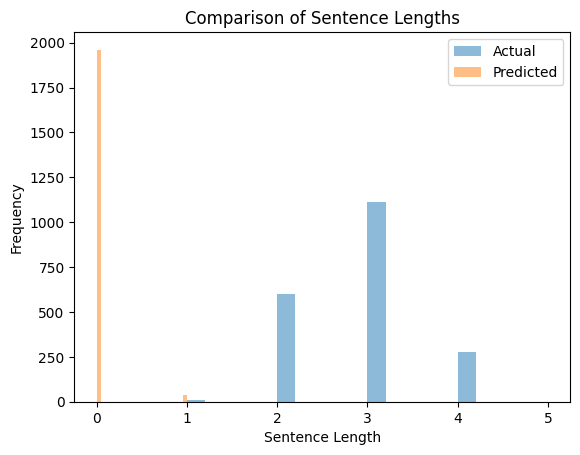

In [33]:
import matplotlib.pyplot as plt

# Panjang kalimat aktual
actual_lengths = [len(sentence.split()) for sentence in test[:, 0]]

# Panjang kalimat hasil prediksi
predicted_lengths = [len(sentence.split()) for sentence in preds_text]

# Visualisasi
plt.hist(actual_lengths, bins=20, alpha=0.5, label='Actual')
plt.hist(predicted_lengths, bins=20, alpha=0.5, label='Predicted')
plt.legend()
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.title("Comparison of Sentence Lengths")
plt.show()


In [34]:
# Ambil beberapa baris acak
sample_df = pred_df.sample(10)

# Tampilkan perbandingan actual vs predicted
for i in range(len(sample_df)):
    print(f"\nActual:    {sample_df.iloc[i]['actual']}")
    print(f"Predicted: {sample_df.iloc[i]['predicted']}")



Actual:    theyre tired
Predicted:        

Actual:    go and see tom
Predicted:        

Actual:    get lost
Predicted:        

Actual:    show it to us
Predicted:        

Actual:    hand it over
Predicted:        

Actual:    replace it
Predicted:        

Actual:    ill attend
Predicted:        

Actual:    im not mean
Predicted:        

Actual:    they loved you
Predicted:        

Actual:    they loved tom
Predicted:        


In [35]:
model.add(LSTM(units=512))  # sebelumnya 256


In [41]:
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle

# Ambil input/output dari data yang sudah dibersihkan
ger_sentences = deu_eng[:, 1]  # Bahasa Jerman
eng_sentences = deu_eng[:, 0]  # Bahasa Inggris

# Buat tokenizer untuk Jerman
tokenizer_de = Tokenizer()
tokenizer_de.fit_on_texts(ger_sentences)

# Buat tokenizer untuk Inggris
tokenizer_en = Tokenizer()
tokenizer_en.fit_on_texts(eng_sentences)

# Simpan tokenizer Jerman
with open("tokenizer_de.pkl", "wb") as f:
    pickle.dump(tokenizer_de, f)

# Simpan tokenizer Inggris
with open("tokenizer_en.pkl", "wb") as f:
    pickle.dump(tokenizer_en, f)
